In [1]:
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import pickle
import seaborn as sns 
import pandas as pd
import numpy as np
import sys
import os
import json
os.chdir(sys.path[0])
from Preprocessing import dataload
from surrogate_model import ANN


In [2]:
save_folder = "ijv_large"
os.makedirs(os.path.join("pic", save_folder), exist_ok=True)
save_path = os.path.join("pic", save_folder)
result_folder = "ctchen_large"

${\bf Plot\;RMSPE\;of\;Testset}$

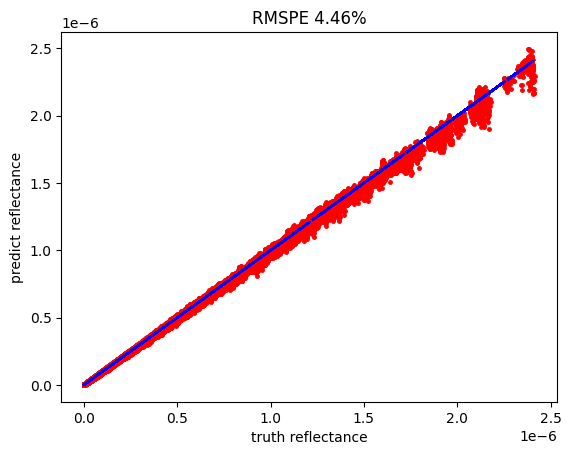

In [3]:
# plot result
with open(os.path.join("model_save", result_folder, "trlog.json"), 'r') as f:
    trlog = json.load(f)

min_loss = min(trlog['test_loss'])
ep = trlog['epoch']
best_model = trlog['best_model']
model = ANN().cuda()
model.load_state_dict(torch.load(best_model))
test_loader = torch.load(os.path.join("model_save",result_folder,"test_loader.pth"))

model.eval()
error = 0
for batch_idx, (data,target) in enumerate(test_loader):
    data,target = data.to(torch.float32).cuda(), target.to(torch.float32).cuda()
    output = model(data)
    # output = output.view(-1)
    y = torch.exp(-output).detach().cpu().numpy()
    x = torch.exp(-target).detach().cpu().numpy()
    error += torch.sqrt(torch.square((torch.tensor(y)-torch.tensor(x))/torch.tensor(x)).mean()).item()
    plt.plot(x,y, 'r.', markersize=5)
    plt.plot(x,x,'b')
error = error/len(test_loader)
plt.title(f"RMSPE {100*error:.2f}%")
plt.xlabel("truth reflectance")
plt.ylabel("predict reflectance")
plt.savefig(os.path.join(save_path,"RMSPE.png"), dpi=300, format='png', bbox_inches='tight')
plt.show()

${\bf Plot\;Loss}$

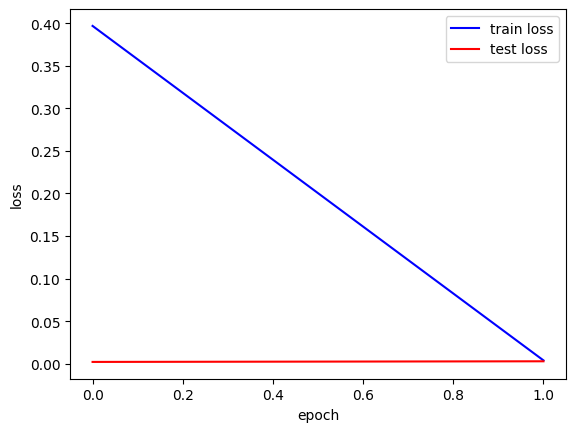

In [4]:
tr_loss = trlog['train_loss']
ts_loss = trlog['test_loss']
epoch = range(trlog['epoch'])
plt.plot(epoch,tr_loss,'blue')
plt.plot(epoch,ts_loss,'r')
plt.legend(["train loss", "test loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig(os.path.join(save_path,"loss.png"), dpi=300, format='png', bbox_inches='tight')
plt.show()

${\bf Plot\;RMSPE\;Each\;SDS}$

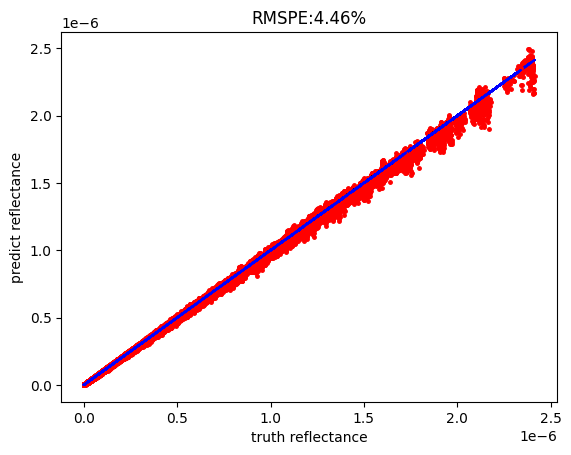

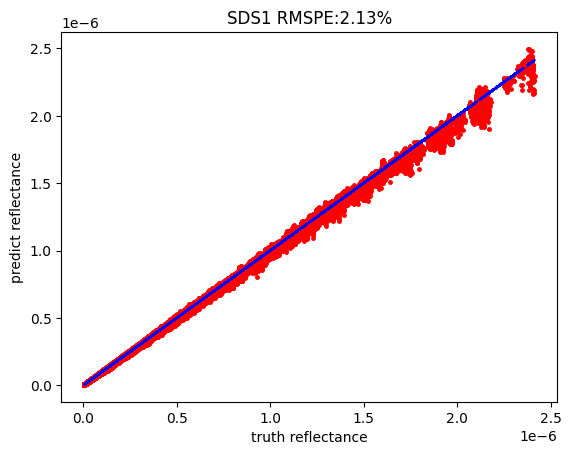

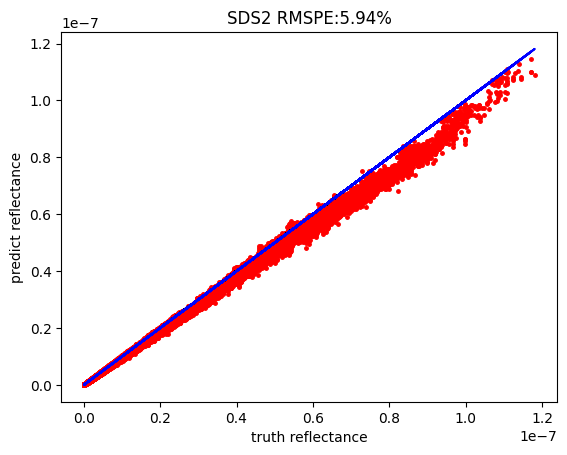

In [5]:
error = 0
for batch_idx, (data,target) in enumerate(test_loader):
    data,target = data.to(torch.float32).cuda(), target.to(torch.float32).cuda()
    output = model(data)
    # output = output.view(-1)
    y = torch.exp(-output).detach().cpu().numpy()
    x = torch.exp(-target).detach().cpu().numpy()
    error += torch.sqrt(torch.square((torch.tensor(y)-torch.tensor(x))/torch.tensor(x)).mean()).item()
    plt.plot(x,y, 'r.', markersize=5)
    plt.plot(x,x,'b')
error = error/len(test_loader)
plt.title(f"RMSPE:{100*error:.2f}%")
plt.xlabel("truth reflectance")
plt.ylabel("predict reflectance")
plt.savefig(os.path.join(save_path,"RMSPE_all.png"), dpi=300, format='png', bbox_inches='tight')
plt.show()

# plot individual
error = 0
for batch_idx, (data,target) in enumerate(test_loader):
    data,target = data.to(torch.float32).cuda(), target.to(torch.float32).cuda()
    output = model(data)
    output = output[:,0].view(-1) # get SDS1_pred
    y = torch.exp(-output).detach().cpu().numpy()
    x = torch.exp(-target[:,0]).detach().cpu().numpy() # get SDS1_truth
    error += torch.sqrt(torch.square((torch.tensor(y)-torch.tensor(x))/torch.tensor(x)).mean()).item()
    plt.plot(x,y, 'r.', markersize=5)
    plt.plot(x,x,'b')
error = error/len(test_loader)
plt.title(f"SDS1 RMSPE:{100*error:.2f}%")
plt.xlabel("truth reflectance")
plt.ylabel("predict reflectance")
plt.savefig(os.path.join(save_path,"RMSPE_SDS_10.png"), dpi=300, format='png', bbox_inches='tight')
plt.show()

error = 0
for batch_idx, (data,target) in enumerate(test_loader):
    data,target = data.to(torch.float32).cuda(), target.to(torch.float32).cuda()
    output = model(data)
    output = output[:,-1].view(-1) # get SDS_last_pred
    y = torch.exp(-output).detach().cpu().numpy()
    x = torch.exp(-target[:,-1]).detach().cpu().numpy() # get SDS_last_truth
    error += torch.sqrt(torch.square((torch.tensor(y)-torch.tensor(x))/torch.tensor(x)).mean()).item()
    plt.plot(x,y, 'r.', markersize=5)
    plt.plot(x,x,'b')
error = error/len(test_loader)
plt.title(f"SDS2 RMSPE:{100*error:.2f}%")
plt.xlabel("truth reflectance")
plt.ylabel("predict reflectance")
plt.savefig(os.path.join(save_path,"RMSPE_SDS_20.png"), dpi=300, format='png', bbox_inches='tight')
plt.show()

${\bf Plot\;Hist}$

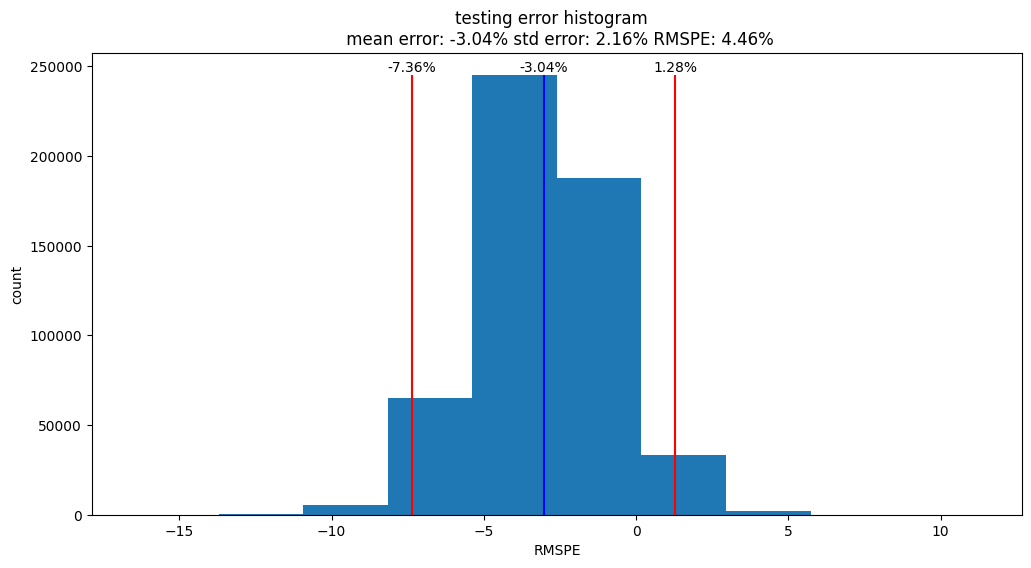

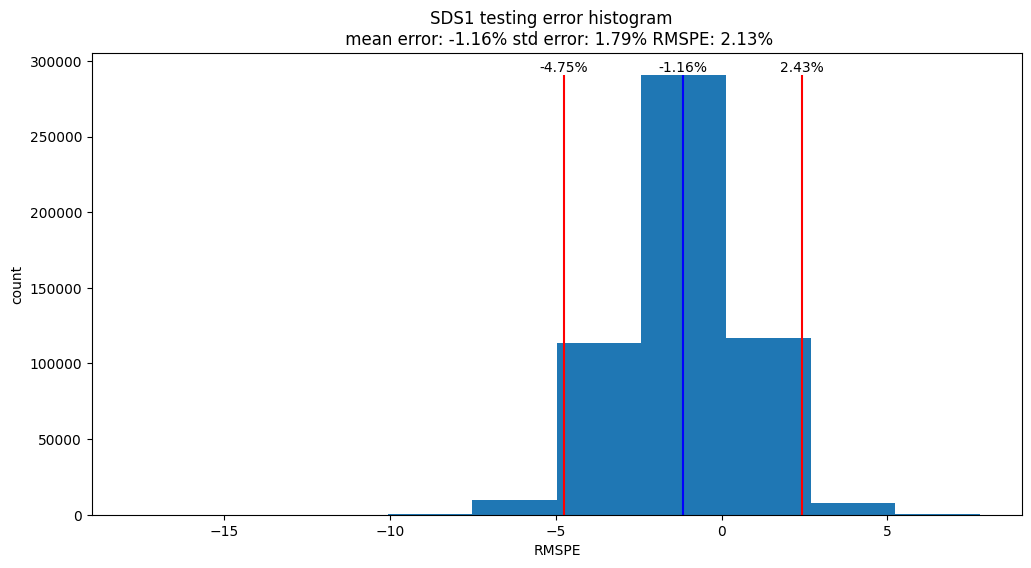

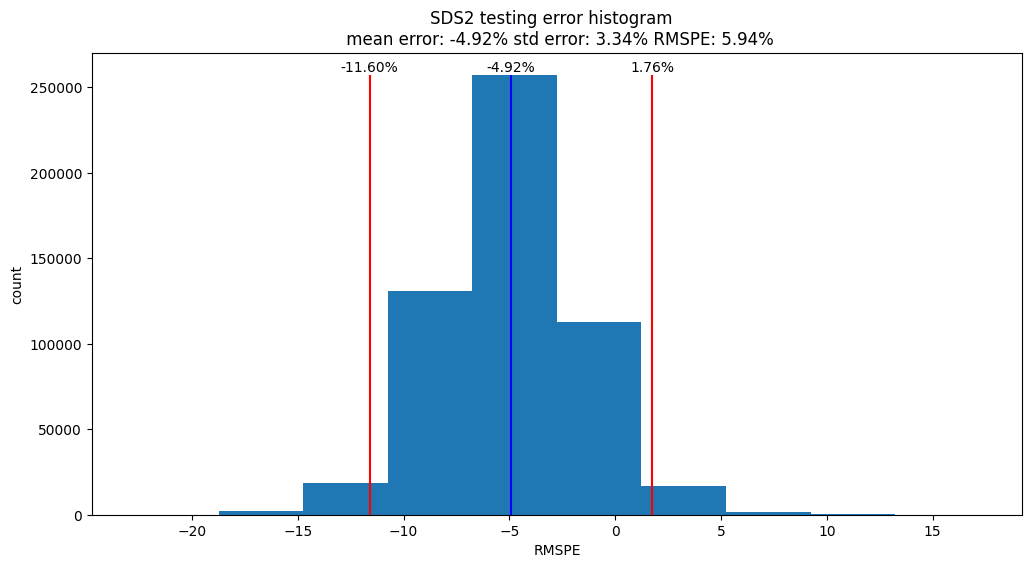

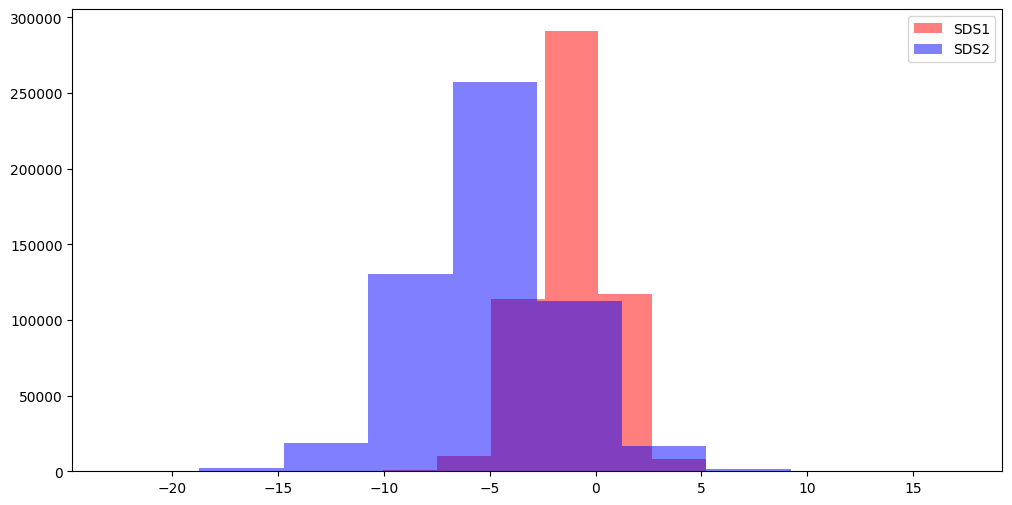

In [6]:
model.eval()
error = 0
error_set = {"error":[]}
for batch_idx, (data,target) in enumerate(test_loader):
    data,target = data.to(torch.float32).cuda(), target.to(torch.float32).cuda()
    output = model(data)
    y = torch.exp(-output).detach().cpu().numpy()
    x = torch.exp(-target).detach().cpu().numpy()
    error += torch.sqrt(torch.square((torch.tensor(y)-torch.tensor(x))/torch.tensor(x)).mean()).item()
    e = 100*((torch.tensor(y)-torch.tensor(x))/torch.tensor(x)).mean(-1).numpy()
    for i in e:
        error_set['error'].append(i)
error = error/len(test_loader)        
error_set = pd.DataFrame(error_set)
plt.figure(figsize=(12,6))
num, bin, patch = plt.hist(data=error_set, x='error')
std = np.std(error_set['error'])
mean = np.mean(error_set['error'])
plt.vlines(mean, 0, max(num), color='b')
plt.vlines(mean+2*std, 0, max(num), color='r')
plt.vlines(mean-2*std, 0, max(num), color='r')
plt.text(mean, max(num),f"{mean:.2f}%",ha='center',va='bottom')
plt.text(mean+2*std, max(num),f"{mean+2*std:.2f}%",ha='center',va='bottom')
plt.text(mean-2*std, max(num),f"{mean-2*std:.2f}%",ha='center',va='bottom')
plt.title(f"testing error histogram  \n mean error: {mean:.2f}% std error: {std:.2f}% RMSPE: {100*error:.2f}%")
plt.xlabel("RMSPE")
plt.ylabel("count")
plt.savefig(os.path.join(save_path,"error_hist_all.png"), dpi=300, format='png', bbox_inches='tight')
plt.show()

error = 0
error_set = {"error":[]}
for batch_idx, (data,target) in enumerate(test_loader):
    data,target = data.to(torch.float32).cuda(), target.to(torch.float32).cuda()
    output = model(data)
    output = output[:,0].view(-1)
    y = torch.exp(-output).detach().cpu().numpy()
    x = torch.exp(-target[:,0]).detach().cpu().numpy()
    error += torch.sqrt(torch.square((torch.tensor(y)-torch.tensor(x))/torch.tensor(x)).mean()).item()
    e = 100*((torch.tensor(y)-torch.tensor(x))/torch.tensor(x)).numpy()
    for i in e:
        error_set['error'].append(i)
error = error/len(test_loader)        
error_set = pd.DataFrame(error_set)
plt.figure(figsize=(12,6))
num, bin, patch = plt.hist(data=error_set, x='error')
std = np.std(error_set['error'])
mean = np.mean(error_set['error'])
plt.vlines(mean, 0, max(num), color='b')
plt.vlines(mean+2*std, 0, max(num), color='r')
plt.vlines(mean-2*std, 0, max(num), color='r')
plt.text(mean, max(num),f"{mean:.2f}%",ha='center',va='bottom')
plt.text(mean+2*std, max(num),f"{mean+2*std:.2f}%",ha='center',va='bottom')
plt.text(mean-2*std, max(num),f"{mean-2*std:.2f}%",ha='center',va='bottom')
plt.title(f"SDS1 testing error histogram  \n mean error: {mean:.2f}% std error: {std:.2f}% RMSPE: {100*error:.2f}%")
plt.xlabel("RMSPE")
plt.ylabel("count")
plt.savefig(os.path.join(save_path,"error_hist_SDS_10.png"), dpi=300, format='png', bbox_inches='tight')
plt.show()

error = 0
error_set = {"error":[]}
for batch_idx, (data,target) in enumerate(test_loader):
    data,target = data.to(torch.float32).cuda(), target.to(torch.float32).cuda()
    output = model(data)
    output = output[:,-1].view(-1)
    y = torch.exp(-output).detach().cpu().numpy()
    x = torch.exp(-target[:,-1]).detach().cpu().numpy()
    error += torch.sqrt(torch.square((torch.tensor(y)-torch.tensor(x))/torch.tensor(x)).mean()).item()
    e = 100*((torch.tensor(y)-torch.tensor(x))/torch.tensor(x)).numpy()
    for i in e:
        error_set['error'].append(i)
error = error/len(test_loader)        
error_set = pd.DataFrame(error_set)
plt.figure(figsize=(12,6))
num, bin, patch = plt.hist(data=error_set, x='error')
std = np.std(error_set['error'])
mean = np.mean(error_set['error'])
plt.vlines(mean, 0, max(num), color='b')
plt.vlines(mean+2*std, 0, max(num), color='r')
plt.vlines(mean-2*std, 0, max(num), color='r')
plt.text(mean, max(num),f"{mean:.2f}%",ha='center',va='bottom')
plt.text(mean+2*std, max(num),f"{mean+2*std:.2f}%",ha='center',va='bottom')
plt.text(mean-2*std, max(num),f"{mean-2*std:.2f}%",ha='center',va='bottom')
plt.title(f"SDS2 testing error histogram  \n mean error: {mean:.2f}% std error: {std:.2f}% RMSPE: {100*error:.2f}%")
plt.xlabel("RMSPE")
plt.ylabel("count")
plt.savefig(os.path.join(save_path,"error_hist_SDS_20.png"), dpi=300, format='png', bbox_inches='tight')
plt.show()

error = 0
error_set = {"SDS10_error":[]}
for batch_idx, (data,target) in enumerate(test_loader):
    data,target = data.to(torch.float32).cuda(), target.to(torch.float32).cuda()
    output = model(data)
    output = output[:,0].view(-1)
    y = torch.exp(-output).detach().cpu().numpy()
    x = torch.exp(-target[:,0]).detach().cpu().numpy()
    error += torch.sqrt(torch.square((torch.tensor(y)-torch.tensor(x))/torch.tensor(x)).mean()).item()
    e = 100*((torch.tensor(y)-torch.tensor(x))/torch.tensor(x)).numpy()
    for i in e:
        error_set['SDS10_error'].append(i)
error = error/len(test_loader)        
error_set = pd.DataFrame(error_set)
plt.figure(figsize=(12,6))
num1, bin1, patch1 = plt.hist(data=error_set, x='SDS10_error', label='SDS1', color='red', alpha=0.5)


error = 0
error_set = {"SDS20_error":[]}
for batch_idx, (data,target) in enumerate(test_loader):
    data,target = data.to(torch.float32).cuda(), target.to(torch.float32).cuda()
    output = model(data)
    output = output[:,-1].view(-1)
    y = torch.exp(-output).detach().cpu().numpy()
    x = torch.exp(-target[:,-1]).detach().cpu().numpy()
    error += torch.sqrt(torch.square((torch.tensor(y)-torch.tensor(x))/torch.tensor(x)).mean()).item()
    e = 100*((torch.tensor(y)-torch.tensor(x))/torch.tensor(x)).numpy()
    for i in e:
        error_set['SDS20_error'].append(i)
error = error/len(test_loader)        
error_set = pd.DataFrame(error_set)
num2, bin2, patch2 = plt.hist(data=error_set,x='SDS20_error',label='SDS2', color='blue', alpha=0.5)
plt.legend()
plt.savefig(os.path.join(save_path,"error_hist_merge.png"), dpi=300, format='png', bbox_inches='tight')
plt.show()
